In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -----------------------
# 1. Load & Preprocess
# -----------------------
df = pd.read_csv("modis_2023_Central_African_Republic.csv")

df.rename(columns={"type": "fire_type"}, inplace=True)
df["acq_time"] = df["acq_time"].astype(str).str.zfill(4)
df["acq_datetime"] = pd.to_datetime(df["acq_date"] + " " + df["acq_time"], format="%Y-%m-%d %H%M")

df["fire_class"] = df["confidence"].apply(lambda x: 1 if x >= 80 else 0)
df["daynight"] = df["daynight"].map({"D": 1, "N": 0})

# Select relevant features
features = ["brightness", "scan", "track", "bright_t31", "frp", "fire_type", "daynight"]
target = "fire_class"

df = df.dropna(subset=features + [target])

# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Split data
X_train, X_val, y_train, y_val = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# ----------------------------
# 2. Create Dataset & Loader
# ----------------------------
class WildfireDataset(Dataset):
    def __init__(self, features, targets):
        self.X = torch.tensor(features.values, dtype=torch.float32)
        self.y = torch.tensor(targets.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = WildfireDataset(X_train, y_train)
val_dataset = WildfireDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# -----------------------------
# 3. Define Lightning Module
# -----------------------------
class WildfireClassifier(pl.LightningModule):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # 2 classes
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# -----------------------------
# 4. Train the Model
# -----------------------------
model = WildfireClassifier(input_dim=len(features))
trainer = pl.Trainer(max_epochs=20, accelerator="auto")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 2.7 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
8         Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Put model in eval mode
model.eval()

# Collect predictions
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for x, y in val_loader:
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # prob of fire_class == 1
        all_targets.extend(y.cpu().numpy())


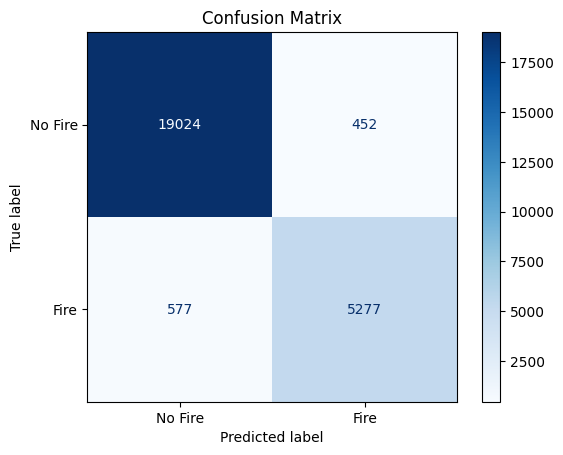

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fire", "Fire"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


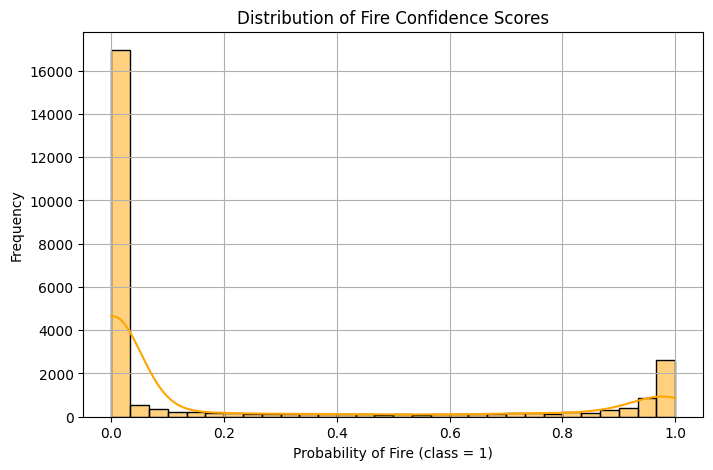

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(all_probs, bins=30, kde=True, color='orange')
plt.title("Distribution of Fire Confidence Scores")
plt.xlabel("Probability of Fire (class = 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


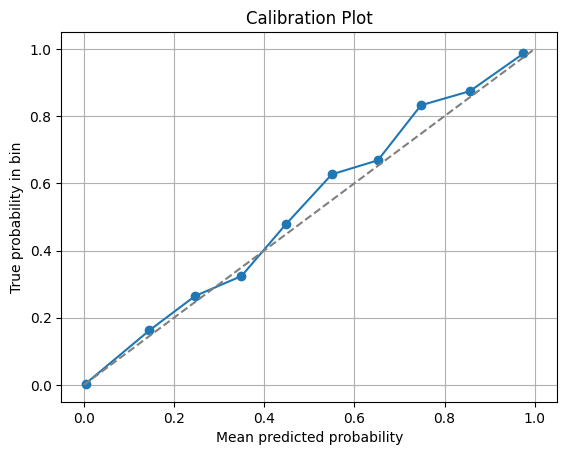

In [5]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(all_targets, all_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Mean predicted probability")
plt.ylabel("True probability in bin")
plt.title("Calibration Plot")
plt.grid(True)
plt.show()
